In [37]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


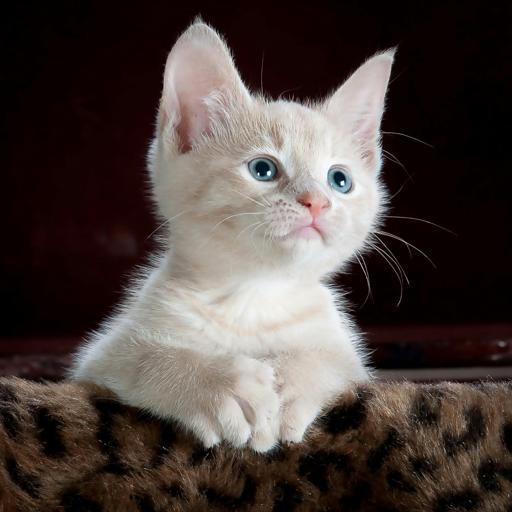

In [61]:

img=Image.open("image.jpg")
img

In [39]:
def preprocess_image(image, image_size=224):
    preprocess=transforms.Compose([
        transforms.Resize([image_size,image_size]),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std=[0.229,0.224,0.225]
        )
    ])

    image_tensor=preprocess(image) # (3,224,224) RGB --> now add batch size as well
    image_tensor=image_tensor.unsqueeze(0) ## adding one batch dimension here
    return image_tensor

image_tensor=preprocess_image(img)

In [52]:
## using hugging face transformers
from transformers import AutoProcessor, SiglipVisionModel,SiglipVisionConfig

processor=AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model=SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224",config=SiglipVisionConfig(vision_use_head=False))

vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [57]:
@dataclass
class SiglipVisionConfig:
    num_channels: int =3
    embed_dim: int =768
    image_size: int=224
    patch_size: int =16

class SiglipVisionEmbeddings(nn.Module): ## image --> patches --> flatten(embeddings) --> add positional embeddings
    def __init__(self,config:SiglipVisionConfig):
        super().__init__()

        self.num_channels=config.num_channels
        self.embed_dim=config.embed_dim
        self.image_size=config.image_size
        self.patch_size=config.patch_size

        self.patch_embedding=nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size, ## because non overlapping
            padding="valid",
        )

        self.num_patches=(self.image_size // self.patch_size) **2
        self.num_positions=self.num_patches
        self.position_embedding=nn.Embedding(self.num_positions,self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand(1,-1),
            persistent=False,
        )

    def forward(self,pixel_values:torch.FloatTensor) -> torch.Tensor:
        B,C,H,W=pixel_values.shape  # (1,768,14,14)
        patch_embeds=self.patch_embedding(pixel_values) # (1,768,14,14)
        embeddings=patch_embeds.flatten(start_dim=2,end_dim=-1) # (1,768,196)
        embeddings=embeddings.transpose(1,2) # (1,196,768)
        embeddings=embeddings+self.position_embedding(self.position_ids) # (1,196,768)
        return embeddings


In [58]:
embd=SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape

torch.Size([1, 196, 768])

In [60]:
### --------------##
##---- (checking if our model implementation (weights and bias matches with Siglip Implementations) ----- ##

from transformers import SiglipVisionModel as HFSiglipVisionModel

our_state_dict=embd.state_dict()
hf_state_dict={
    k.replace("vision_model.embeddings.",""):v for k,v in vision_model.state_dict().items() if "vision_model.embeddings." in k
}
our_state_dict.update(hf_state_dict) ## basically updating our state dict with Hugging face SigLip weights and bias
embd.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output=embd(image_tensor)
    hf_output=vision_model.vision_model.embeddings(image_tensor)
    print("Max difference between our output and HF output:",torch.max(torch.abs(our_output-hf_output)))

Max difference between our output and HF output: tensor(0.)


## Simple Single Head and MHA Implementation

In [62]:
import math

class Head(nn.Module):
    ###------ single head of multi-head attention ----- ###
    def __init__(self,n_in,n_head,context_length):
        super().__init__()
        self.head_size=n_head ## feature dimension of our input tensor
        self.key=nn.Linear(n_in,n_head,bias=False) ## n_in and n_head should technically be same according to implementation
        self.query=nn.Linear(n_in,n_head,bias=False)
        self.value=nn.Linear(n_in,n_head,bias=False)

    def forward(self,x):
        B,T,C=x.shape ## B:batch_size, T:no_of_patches, C:no of channels(768)  
        k=self.key(x)
        q=self.query(x)
        v=self.query(x)
        wei=(q@k.transpose(-2,-1))*(1.0/math.sqrt(self.head_size)) ## attention before softmax, in LLM this is where we make values 0 for causal/pad masking
        wei=torch.softmax(wei,dim=-1)
        out=wei@v
        return out

''' in this implementation, n_in is basically the full input dimension 768 and n_head is basically each head size,which 
makes each self.k,q,v matrix as (768,64) which is not the case in actual implementations, as correctly done in siglip '''

class MultiHeadAttention(nn.Module):
    ''' for this implementation we concatinate all heads after passing each head through the transformer'''
    def __init__(self,num_head,n_in, head_size,context_length):
        super().__init__()
        self.head_size=head_size
        self.num_head=num_head
        self.heads=[Head(n_in,self.head_size,context_length) for _ in range(self.num_head)]
        self.proj=nn.Linear(n_in,n_in) ## final projection after (Q.K_T)@V 

    def forward(self,x):
        out=[h(x) for h in self.heads]
        out=torch.concat(out,dim=-1)
        out=self.proj(out)
        return out

## Siglip Implementation of MHA (using vector represenations)

In [72]:
@dataclass
class SiglipVisionConfig:
    num_channels: int=3
    image_size: int =224 ## input image size
    patch_size: int =16
    num_attention_heads: int=12
    hidden_state: int=768
    attention_dropout: float=0.0 ## probability of dropout

class SiglipAttention(nn.Module):
    def __init__(self,config:SiglipVisionConfig):
        super().__init__()
        self.config=config
        self.embed_dim=config.hidden_state
        self.num_heads=config.num_attention_heads
        self.dropout=config.attention_dropout

        self.k_proj=nn.Linear(self.embed_dim,self.embed_dim) ## basically we mutiply our k,q,v (B,197,768) by (768,768)
        self.q_proj=nn.Linear(self.embed_dim,self.embed_dim) ## 197 is no of patches (including CLS)
        self.v_proj=nn.Linear(self.embed_dim,self.embed_dim) ## 768 is our embedding dimension
        self.out_proj=nn.Linear(self.embed_dim,self.embed_dim)

    def forward(self, hidden_states):
        '''hidden states is basically the input vector ( using ODD name for an input image tensor )'''
        B,T,C=hidden_states.shape ## (1,197,768)
        q_states=self.q_proj(hidden_states) ## (1,197,768) --> (1,197,768)
        k_states=self.k_proj(hidden_states)
        v_states=self.v_proj(hidden_states)    

        '''now  splitting these matrices(feature dimension) (Q,K,V) on basis of number of heads --> this will be our multi head attention'''
        q_states=q_states.view(B,T,self.num_heads,C // self.num_heads).transpose(1,2) # (1,197,768) --> (1,197,12,64) --> (1,12,197,64) {for each head , there are all patches and 64 feature dimensions}
        k_states=k_states.view(B,T,self.num_heads,C // self.num_heads).transpose(1,2) # (1,197,768) --> (1,197,12,64) --> (1,12,197,64) {for each head , there are all patches and 64 feature dimensions}
        v_states=v_states.view(B,T,self.num_heads,C // self.num_heads).transpose(1,2) # (1,197,768) --> (1,197,12,64) --> (1,12,197,64) {for each head , there are all patches and 64 feature dimensions}
        
        ''' computing attention for each head, pytorch will implicitly do it for all 12 heads in a loop'''    
        attn_weights=(q_states @ k_states.transpose(-2,-1)) * (1.0/math.sqrt(k_states.size(-1))) ## (1,12,197,64) --> (1,12,197,197)
        attn_weights=torch.softmax(attn_weights,dim=-1).to(q_states.dtype) #(1,12,197,197)
        attn_weights=F.dropout(attn_weights,p=self.dropout,training=self.training) ## self.training is directly inhereted from nn.Module
        attn_outs=attn_weights@v_states # (1,12,197,197) --> (1,12,197,64)
        attn_outs=attn_outs.transpose(1,2) # (1,12,197,64) --> (1,197,12,64)
        attn_outs=attn_outs.reshape(B,T,C).contiguous() #(1,197,12,64) --> (1,197,768)
        attn_outs=self.out_proj(attn_outs) # (1,197,768)--> (1,197,768)
        return attn_outs 

In [73]:
batch_size=1
num_patches=196
embed_dim=768

'''creating a random input image tensor'''
hidden_states=torch.rand(batch_size,num_patches,embed_dim)
config=SiglipVisionConfig(
    attention_dropout=0.0,
    num_attention_heads=12,
    hidden_state=768
)

attention=SiglipAttention(config)
output=attention(hidden_states)

print(f"shape of Input Tensor:{hidden_states.shape}")
print(f"shape of Output Tensor: {output.shape}")

shape of Input Tensor:torch.Size([1, 196, 768])
shape of Output Tensor: torch.Size([1, 196, 768])


In [75]:
'''' Verifying that our implementation of Siglip attention matches their original Siglip attention'''
hf_state_dict=vision_model.vision_model.state_dict()
our_state_dict=attention.state_dict()

key_mapping = {
    'k_proj.weight': 'encoder.layers.0.self_attn.k_proj.weight',
    'k_proj.bias': 'encoder.layers.0.self_attn.k_proj.bias',
    'v_proj.weight': 'encoder.layers.0.self_attn.v_proj.weight',
    'v_proj.bias': 'encoder.layers.0.self_attn.v_proj.bias',
    'q_proj.weight': 'encoder.layers.0.self_attn.q_proj.weight',
    'q_proj.bias': 'encoder.layers.0.self_attn.q_proj.bias',
    'out_proj.weight': 'encoder.layers.0.self_attn.out_proj.weight',
    'out_proj.bias': 'encoder.layers.0.self_attn.out_proj.bias'
}

for our_key,hf_key in key_mapping.items():
    our_state_dict[our_key].copy_(hf_state_dict[hf_key])

attention.load_state_dict(our_state_dict)


with torch.no_grad():
    our_output=attention(hidden_states)
    hf_output=vision_model.vision_model.encoder.layers[0].self_attn(hidden_states)[0]
    max_diff=torch.max(torch.abs(our_output-hf_output))
    print(f"Max difference between our implementation and HF output:{max_diff:.6f}")
    print((torch.isclose(our_output, hf_output, atol=1e-6)==0).sum())

Max difference between our implementation and HF output:0.000001
tensor(0)
